<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> ILI285 Computación Científica I</h1>
    <h1> Tarea N°4: Gradiente Descendente - Newton Multivariado</h1>
    <h3> [S]cientific [C]omputing [T]eam 2018</h3>
</center>

<p>
<center>_Mayo 2018_ </center>
</p>

# Introducción

El objetivo de esta tarea es usar los métodos de resolución de sistema de ecuaciones lineales, además de búsqueda de ceros de sistemas no lineales con newton multivariado y gradiente descendente vistos en clases, para poder resolver un problema de optimización. Para esto, buscaremos minimizár una función objetivo que describiremos posteriormente.

# Conformación molecular y optimización numérica [[1]](#ref)

En el contexo de dinámica molecular [[2]](#ref), un par de átomos o moleculas neutras estan sujetas a dos fuerzas: Una fuerza atractiva que actua a grandes distancias entre moléculas, conocida como la fuerza de Van der Waals, y una fuerza repulsiva entre moléculas actuando a pequeñas distancias, conocida como la repulsión de Pauli. Este comportamiento es modelado matemáticamente mediante el potencial de Lennard-Jones. Este potencial se define para dos moléculas como:

$$
U(r) = \frac{1}{r^{12}} - \frac{2}{r^6}
$$

Donde su gráfica es la siguiente:
<figure>
  <img src="Lennard-Jones-Potencial.png" height="58%" width = "58%" >
  <center>
  <figcaption>Figura 1: El potencial de Lennard-Jones $U(r) = r^{-12} - 2r^{-6}$. La energía mínima es $-1$, que se alcanza en $r = 1$.</figcaption>
  </center>
</figure>

Para un *cluster* de moléculas con posiciones $(x_1, y_1, z_1), \ldots, (x_n, y_n, z_n)$ el potencial de Lennard-Jones se obtiene de la siguiente forma:

$$
 U(x_1,y_1,z_1, x_2, y_2, z_2, \dots) = \sum_{i < j} \left( \frac{1}{r_{ij}^{12}} - \frac{2}{r_{ij}^6} \right)
$$

Para cada par de moléculas, $r_{ij}$ denota la distancia entre la molécula con posición $(x_i, y_i, z_i)$ con la molécula $(x_j, y_j, z_j)$ mediante:

$$
r_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2 + (z_i - z_j)^2}
$$

Puede usar la siguiente función para las posiciones iniciales de sus partículas [[3]](#ref):

In [132]:
import copy
import hilbert

#N: Number of particles. must be > 2.
#p: The number of iterations used in constructing the Hilbert curve, must be > 0. More info in [6] Reference.
#Consider this like a seed
    
def initial_guess(N):
    p = 10
    #coor: Size of every row (in this case 3, because we hace x,y,z coordinates).
    coor = 3
    if (2**coor*p - 1 < N):
        print("You have to increase the value of p.")
        return None
    #list_pos: list with the position
    list_pos = []
    #Generate the data
    hilbert_curve = hilbert.HilbertCurve(p, coor)
    for ii in range(N):
        list_pos.append(hilbert_curve.coordinates_from_distance(ii))
    #Search if we have the [0,0,0] and [0,0,1] in list
    f1 = np.where(np.all(list_pos == np.array([0,0,0]),axis=1))[0]
    f2 = np.where(np.all(list_pos == np.array([0,0,1]),axis=1))[0]
    #If we dont have those elements, increase the p value until we obtain them
    while (len(f1) == 0 or len(f2) == 0):
        list_pos = []
        p +=1
        coor = 3
        list_pos = []
        hilbert_curve = hilbert.HilbertCurve(p, coor)
        for ii in range(N):
            list_pos.append(hilbert_curve.coordinates_from_distance(ii))
        f1 = np.where(np.all(list_pos == np.array([0,0,0]),axis=1))[0]
        f2 = np.where(np.all(list_pos == np.array([0,0,1]),axis=1))[0]
    
    list_pos = np.array(list_pos)
    
    #Search the [0,0,0] in list, and swap this row by the first row
    first = np.zeros(3)
    f = np.where(np.all(list_pos == first,axis=1))[0][0]
    aux = list_pos[0,:].copy() 
    list_pos[0,:] = list_pos[f,:]
    list_pos[f,:] = aux
    
    #Search the [0,0,1] in list, and swap this row by the second row
    second = np.array([0,0,1])
    f = np.where(np.all(list_pos == second,axis=1))[0][0]
    aux = list_pos[1,:].copy() 
    list_pos[1,:] = list_pos[f,:]
    list_pos[f,:] = aux
    
    return list_pos

# Pregunta 1 [10 pts]

Estudie el potencial de Lennard-Jones. Encuentre y comente: 
 - El mínimo de la función.
 - Cuando la pendiente o derivada es igual a $0$ $\displaystyle \left(\frac{\partial U(r)}{\partial r} = 0\right)$.

Además describa: 
 - ¿Que comportamiento se esperaría de las moléculas cuando $r < 1$? ¿y cuando $r > 1$? ¿y cuando $r = 1$?

Primero, escribiremos la ecuación del potencial de Lennard-Jones de forma mas genera:

$$
U_{p}(r) = U_{0}\,\Big(\Big(\frac{r_{0}}{r}\Big)^{12} - \Big(\Big(\frac{2\,r_{0}}{r}\Big)^6\Big)
$$

Donde las variables de esta ecuación significan:

 i) $U_{p}(r)$ Es el valor final del potencial de Lennard-Jones 
 
 ii) $ U_{0}$ y $r_{0}$ Son constantes determinadas por la estructura de las moléculas individuales
 
iii) $r$ es la distancia de entre los centros moleculares.

Si consideramos nuestras constaste $ U_{0}$ y $r_{0}$ iguales a 1, entonces llegamos a nuestra ecuación original

$$
U(r) = \frac{1}{r^{12}} - \frac{2}{r^6}
$$

Por lo cual si analizamos las funciones tenemos que si $r > r_{0}$ la fuerza sera altamente atractiva y la pendiente positiva en el caso opuesta si $r < r_{0}$ la fuerza es altamente repulsiva y la pendiente negativa y finalmente si $r = r_{0}$ la fuerza en nula o llegamos a un mínimo de la energía potencial.

Para nuestro caso de estudio, si $r_{0} = 1$ estas mismas condiciones se cumplen cuando $r > 1$ , $r < 1$ y $r = 1$ respectivamente


Otra forma de sacar el mínimo de la función es derivando la ecuación genérica respecto a r, lo cual tenemos que:

$$
\frac{dU_{p}(r)}{dr} = \Big( \frac{-12\,r_{0}^{12}}{r^{13}} + \frac{12\,r_{0}^{6}}{r^{7}}\Big)
$$

Si igualo mi derivada a 0 tenemos que:

$$
\frac{12\,r_{0}^{6}}{r^{7}}=\frac{12\,r_{0}^{12}}{r^{13}}
$$
Como sabemos que nuestro caso de estudio $r_{0} = 1$ tenemos que

$$
r^6 = 1
$$

Por lo tanto el mínimo de energía se alcanza cuando

$$
r = 1
$$

Finalmente, el mínimo de energía representa cuando se llega a una fuerza de equilibrio:

<br>
<figure>
  <img src="F0.png" height="58%" width = "58%" >
  <center>
      <figcaption>Figura 2: Representación grafica de potencial minimo o mínimo de energía</figcaption>
  </center>
</figure>

# Pregunta 2 [50 pts]

Para minimizar el potencial de Lennard-Jones, se debe ubicar un conjunto de moléculas en lugares específicos, ya que el valor de el potencial de Lennard-Jones depende de la distancia que exista entre ellas. Para esto, usaremos el algoritmo Newton-Raphson multivariado [[4]](#ref) junto al criterio de la primera derivada, que nos dice que un máximo o mínimo de una función se encuentra cuando el gradiente es $0$. 
Utilizando esto ultimo, se debe utilizar Newton-Raphson sobre  $\displaystyle \nabla\left(U(x_1,\dots)\right) = \left( \frac{\partial U}{\partial x_1},\ldots, \frac{\partial U}{\partial x_n}, \frac{\partial U}{\partial y_1},  \ldots, \frac{\partial U}{\partial y_n}, \frac{\partial U}{\partial z_1}, \ldots, \frac{\partial U}{\partial z_n} \right) = \mathbf{0}$. Trabajaremos con el supuesto de que dos particulas no pueden estar en el mismo lugar del espacio al mismo tiempo. En un principio esto se puede manejar entregandole al algoritmo posiciones iniciales no identicas de las partículas, pero nada nos asegura que durante las iteraciones de Newton-Raphson se cumpla este supuesto. Por ello, vamos a agregar un factor $\delta>0$ para evitar singularidades, por lo que la energia potencial total de Lennard-Jones modificada es:

$$
U(x_1,\dots) = \sum_{i < j} \left( \frac{1}{r_{ij}^{12} + \delta} - \frac{2}{r_{ij}^6 + \delta} \right)
$$

- Implemente Newton-Raphson para encontrar las posiciones de $N$ partículas (Se recomienda utilizar la libreria *SymPy* [[5]](#ref) ( [[Apéndice]](#apendix) ) . Para esto, fije la primera partícula en la posición $(0,0,0)$ y la segunda partícula en $(0,0,z_2)$, por lo que $z_2$ y las demás variable deberán ser determinadas por su algoritmo. 

Algunas posiciones iniciales de las partículas para probar su algoritmo (cuando $\delta = 0$) son las siguientes:

In [133]:
import numpy as np

#N = 3
N_3 = np.array([[ 0.        ,  0.        ,  0.        ],
      [ 0.        ,  0.        , -0.57170632],
      [-0.7       , -0.1       , -0.3       ]])

#N = 4 first case
N1_4 = np.array([[ 0.        ,  0.        ,  0.        ],
      [ 0.        ,  0.        , -0.999     ],
      [-0.85654066, -0.12192982, -0.499     ],
      [-0.400861  ,  0.767187  , -0.499     ]])

#N=4 second case
N2_4= np.array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.999     ],
       [-0.85654066, -0.12192982, -0.499     ],
       [-0.17283300000000001  , -0.847807  , -0.499     ]])
print("Para N = 3:")
print(N_3)

print("Para N = 4 primer caso:")
print(N1_4)

print("Para N = 4 segundo caso:")
print(N2_4)

Para N = 3:
[[ 0.          0.          0.        ]
 [ 0.          0.         -0.57170632]
 [-0.7        -0.1        -0.3       ]]
Para N = 4 primer caso:
[[ 0.          0.          0.        ]
 [ 0.          0.         -0.999     ]
 [-0.85654066 -0.12192982 -0.499     ]
 [-0.400861    0.767187   -0.499     ]]
Para N = 4 segundo caso:
[[ 0.          0.          0.        ]
 [ 0.          0.         -0.999     ]
 [-0.85654066 -0.12192982 -0.499     ]
 [-0.172833   -0.847807   -0.499     ]]


Sin embargo, recuerde que estos **son casos de prueba. Su algoritmo deberá resolver el problema con cualquier número de partículas**. Para esto, su función debe seguir la siguiente estructura:
```python
'''
Input: 
initial_pos - (Nx3-array) bidimensional array with the initial position of the N particles. 
m - (int) number of iterations. 
solver - (function) Function to solve the linear system equations. You can choose between PALU or Gauss-seidel.
delta - (double) Correction factor.
threshold_GS - (int) Error threshold for Gauss-Seidel. Note: Anyways you should limit Gauss-Seidel to a 10000 in the worst case.

Output:
points - ( Nx3xm - array) tridimensional array with the positions of the N particles in every iteration.
energy - ( mx1 - array) array with the value of the total energy for the N particles in every iteration.
computation_time_by_iteration - (mx1 - array) array with the computation time of each iteration of the algoritm.
'''

def Newton_Raphson(initial_pos, m, solver, delta=0, K=1):
    ...
    return points, energy, computation_time_by_iteration
```

Donde usted debe implementar el *solver* para resolver el sistema de ecuaciones que habra en cada iteración. En el input se debe escoger entre *PALU* o *Gauss-seidel*.

In [134]:
from sympy import *

def gauss_seidel(A, b, n_iter):
    n = A.shape[0]
    X = np.empty((n_iter, n))
    X[0] = np.zeros(n)
    R = np.tril(A)
    U = A-R
    for i in range(1, n_iter):
        X[i] = solve_triangular(R, b-np.dot(U, X[i-1]), upper=False)
    return X[-1]

def error(X, y):
    D = X-y
    err = np.linalg.norm(D, axis=1, ord=np.inf)
    return err

def solve_triangular(A, b, upper=True):
    n = b.shape[0]
    x = np.zeros_like(b)
    if upper==True:
        #perform back-substitution
        x[-1] = (1./A[-1,-1]) * b[-1]
        for i in range(n-2, -1, -1):
            x[i] = (1./A[i,i]) * (b[i] - np.sum(A[i,i+1:] * x[i+1:]))
    else:
        #perform forward-substitution
        x[0] = (1./A[0,0]) * b[0]
        for i in range(1,n):
            x[i] = (1./A[i,i]) * (b[i] - np.sum(A[i,:i] * x[:i]))
    return x

def solve_palu(A, b, show=False):
    P,L,U = palu_decomp(A, show)
    #A.x = b -> P.A.x = P.b = b'
    b = np.dot(P,b)
    # L.c = b' with c = U.x
    c = solve_triangular(L, b, upper=False)
    x = solve_triangular(U, c)
    return x

def palu_decomp(A, show=False):
    N,_ = A.shape
    P = np.identity(N)
    L = np.zeros((N,N))
    U = np.copy(A)
    if show:
        print('Initial matrices')
        print('P = '); print(np.array_str(P, precision=2, suppress_small=True))
        print('L = '); print(np.array_str(L, precision=2, suppress_small=True))
        print('U = '); print(np.array_str(U, precision=2, suppress_small=True))
        print('----------------------------------------')
    #iterating through columns
    for j in range(N-1):
        #determine the new pivot
        p_index = np.argmax(np.abs(U[j:,j]))
        if p_index != 0:
            row_perm(P, j, j+p_index)
            row_perm(U, j, j+p_index)
            row_perm(L, j, j+p_index)
            if show:
                print('A permutation has been made')
                print('P = '); print(np.array_str(P, precision=2, suppress_small=True))
                print('L = '); print(np.array_str(L, precision=2, suppress_small=True))
                print('U = '); print(np.array_str(U, precision=2, suppress_small=True))
                print('----------------------------------------')
        #iterating through rows
        for i in range(j+1,N):
            L[i,j] = U[i,j]/U[j,j]
            U[i] -= L[i,j]*U[j]
            if show:
                print('P = '); print(np.array_str(P, precision=2, suppress_small=True))
                print('L = '); print(np.array_str(L, precision=2, suppress_small=True))
                print('U = '); print(np.array_str(U, precision=2, suppress_small=True))
                print('----------------------------------------')
    np.fill_diagonal(L,1)
    return P,L,U

def row_perm(A, i, j):
    tmp = np.copy(A[i])
    A[i] = A[j]
    A[j] = tmp

In [135]:
import time

def Newton_Raphson(initial_pos, m, solver, delta, K,Iteration=True):
    start_time = time.clock()
    N = initial_pos.shape[0]
    variables= N
    grad = []
    hessiana = []
    aux_list = []
    value_dic = {}
    final_points = []
    final_energy = []
    final_time = []
    X = symbols('x0:%d'%variables)
    Y = symbols('y0:%d'%variables)
    Z = symbols('z0:%d'%variables)
    U = 0
    
    
    for i in range(0,initial_pos.shape[0]-1):
        for j in range(i,initial_pos.shape[0]-1):  
            U += +1/(sqrt((X[i]-X[j+1])**2 + (Y[i]-Y[j+1])**2 + (Z[i]-Z[j+1])**2)**12+delta) - 2/(sqrt((X[i]-X[j+1])**2 + (Y[i]-Y[j+1])**2 + (Z[i]-Z[j+1])**2)**6+delta)

        
    for x,y,z in zip(X,Y,Z):  #Genera el vector Gradiente
        grad.append(diff(U,x))
        aux_list.append(x)
        grad.append(diff(U,y))
        aux_list.append(y)
        grad.append(diff(U,z))
        aux_list.append(z)
    
    ################################33
    extra_list = aux_list[5:]
    extra_pos = initial_pos.flat[5:]
    for i,j in zip(extra_list,list(extra_pos)):  #crea diccionario con los valores de Xn,Yn,Zn
        value_dic[i] = j
    U_evaluado = U.subs({"x0":0,"y0":0,"z0":0,"x1":0,"y1":0})
    grad_aux = []
    for x,y,z in zip(X,Y,Z):  #Genera el vector Gradiente
        if(diff(U_evaluado,x) != 0):
            grad_aux.append(diff(U_evaluado,x))
        if(diff(U_evaluado,y) != 0):
            grad_aux.append(diff(U_evaluado,y))
        if(diff(U_evaluado,z) != 0):
            grad_aux.append(diff(U_evaluado,z))
    hessiana = [[U_evaluado.diff(x).diff(y) for x in extra_list] for y in extra_list]
    for i in range(m):
        if(Iteration == True):
            print("Va en la iteración: ",i)
        posiciones = [0.0,0.0,0.0,0.0,0.0]
        for key in value_dic.values():
            posiciones.append(key)
        
        points = []
        for parte in range(0,len(posiciones),3):
            chunk = posiciones[parte:parte+3]
            points.append(chunk)
        A = Matrix(hessiana).subs(value_dic)
        b = ((Array(grad_aux).subs(value_dic))*-1)
        if(solver == solve_palu):
            palu_sol  = solver(A, b, show=False)  
            for key,new_value,old_value in zip(value_dic.keys(), palu_sol,value_dic.values()):   #Actualización de posiciones
                value_dic.update({key:(old_value+new_value)})
        elif(solver == gauss_seidel):
            palu_sol  = solver(np.asarray(A), np.asarray(b),K)  
            for key,new_value,old_value in zip(value_dic.keys(), palu_sol,value_dic.values()):   #Actualización de posiciones
                value_dic.update({key:(old_value+new_value)})
        final_energy.append(U_evaluado.subs(value_dic))
        final_points.append(points)
        finalt = time.clock()-start_time
        final_time.append(finalt)

        
    #################################
    return final_points, np.asarray(final_energy), np.asarray(final_time) 
    
N = initial_guess(5).astype(float)
a,b,c = Newton_Raphson(N,5,solve_palu,0,30)
print("Posiciones Por Iteración: ")
print("\n")
print(np.asarray(a))
print("\n")
print("Energias Por Iteración: ")
print("\n")
print(b.reshape(len(b),1))
print("\n")
print("Tiempo por interación en segundos: ")
print("\n")
print(c.reshape(len(c),1))
print("\n")

Va en la iteración:  0
Va en la iteración:  1
Va en la iteración:  2
Va en la iteración:  3
Va en la iteración:  4
Posiciones Por Iteración: 


[[[0.0 0.0 0.0]
  [0.0 0.0 1.0]
  [0.0 1.0 1.0]
  [0.0 1.0 0.0]
  [1.0 1.0 0.0]]

 [[0.0 0.0 0.0]
  [0.0 0.0 0.991325454368163]
  [-0.0261141787143892 0.991343390612312 0.968262259117680]
  [0.191919187055110 0.991132926983420 -0.0226623551344451]
  [1.19366845047879 1.17719860222545 -0.160806217903260]]

 [[0.0 0.0 0.0]
  [0.0 0.0 0.991140189492605]
  [-0.0138943484244866 0.991062897140926 0.952287230163108]
  [-0.402144853128692 1.06217786295409 -0.119243568871643]
  [0.663009872299577 0.776532386135350 0.282033034549819]]

 [[0.0 0.0 0.0]
  [0.0 0.0 1.00830754891126]
  [0.0184554378817407 0.985914162988604 0.782471397313607]
  [-0.765480817029645 1.64398423219776 -0.749850955876626]
  [0.493517322984749 0.982481755004034 -0.184138022264392]]

 [[0.0 0.0 0.0]
  [0.0 0.0 0.916293157969357]
  [-4.75962194450157 -0.323063658306761 -2.00366227533

# Pregunta 3 [30 pts]

 - Implemente un *widget* que haga variar el número de particulas, número de iteraciones de Newton, $\delta$ y número de iteraciones de Gauss-Seidel, el cual debe mostrar en el mismo gráfico:
 
     - Energía total vs iteracion, y Tiempo de computación por iteración, en el mismo gráfico con diferentes escalas [[6]](#ref).
     - Mostrar las trayectorias de las particulas en un sketch 3D en función del número de iteración.

 Nota, en ambos casos debe mostrar el output usando PALU y Gauss-Seidel al mismo tiempo. Use leyendas para indicar que está graficando.


 - Según los gráficos realizados, ¿Qué método es más conveniente y en que condiciones? Comente el porque de su elección. 

In [136]:
import matplotlib.pyplot as plt
from ipywidgets import *

#def update_D_range(*args):
#    D_widget.max = V_widget.value

def plot_3(N,m,d,k):
    ini = initial_guess(N).astype(float)
    posiciones_palu, energias_palu, tiempos_palu = Newton_Raphson(ini,m,solve_palu,d,k,Iteration=False)
    posiciones_gs, energias_gs, tiempos_gs = Newton_Raphson(ini,m,gauss_seidel,d,k,Iteration=False)
    
    fig, ax1 = plt.subplots(figsize=(22,10))
    t = list(range(0,m))
    ax1.plot(t,tiempos_palu,"-g",tiempos_gs,"-r",label = "Tiempo en segundos",linewidth=3)
    ax1.set_xlabel('Iteraciones')
    ax1.set_ylabel('Tiempo en segundos',color="r",fontsize = 20)
    ax1.legend(loc=0,fontsize=25)

    ax2 = ax1.twinx()
    ax2.plot(t, energias_palu,"-c",energias_gs,"-b",label = "Energia",linewidth=3)
    ax2.set_ylabel('Energia',color="b",fontsize = 20)
    ax2.legend(loc=1,fontsize=25)
    
    
    fig.tight_layout()
    plt.legend(fontsize = 25)
    plt.grid()
    plt.show()    
    

N_widget = IntSlider(min=0, max=10, step=1,value = 3 ,continuous_update=False)
m_widget = IntSlider(min=0, max=50, step=1,value = 10 ,continuous_update=False)
d_widget = IntSlider(min=0, max=100, step=1,value = 0 ,continuous_update=False)
k_widget = IntSlider(min=0, max=50, step=1,value = 40 ,continuous_update=False)

interact(plot_3,N=N_widget,m=m_widget,d=d_widget,k=k_widget)



interactive(children=(IntSlider(value=3, continuous_update=False, description='N', max=10), IntSlider(value=10, continuous_update=False, description='m', max=50), IntSlider(value=0, continuous_update=False, description='d'), IntSlider(value=40, continuous_update=False, description='k', max=50), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_3>

In [156]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
#import plotly.graph_objs as go

import numpy as np

ini = initial_guess(3).astype(float)
data, b, c = Newton_Raphson(ini,5,solve_palu,5,5,Iteration=False)
x = (np.asarray(data[-1])[:,0])
y = (np.asarray(data[-1])[:,1])
z = (np.asarray(data[-1])[:,2])

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

ModuleNotFoundError: No module named 'plotly'

IndexError: index 3 is out of bounds for axis 0 with size 3

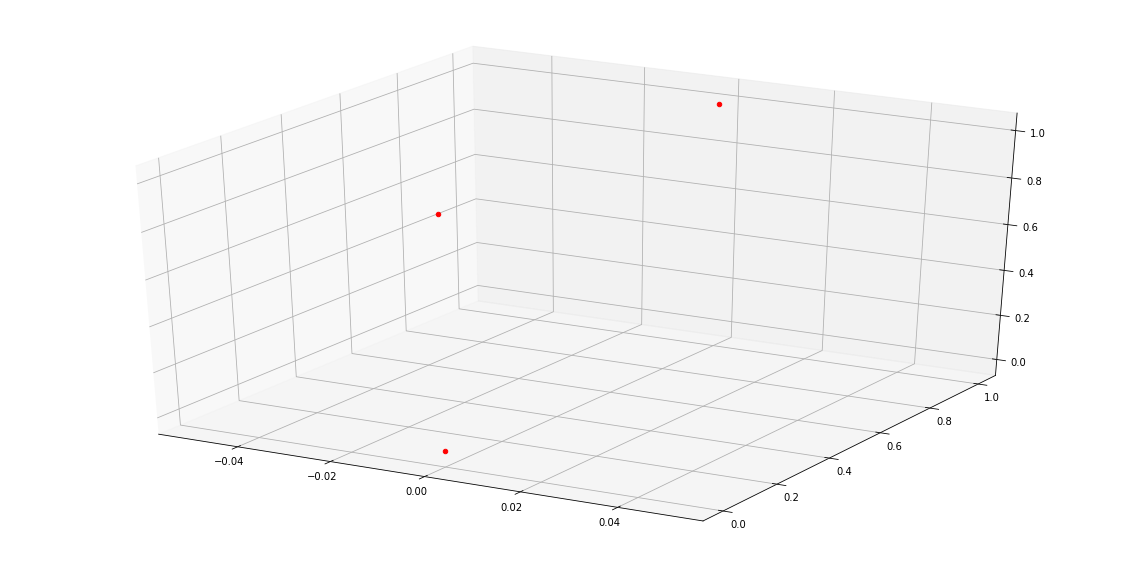

In [137]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

ini = initial_guess(3).astype(float)
data, b, c = Newton_Raphson(ini,5,solve_palu,5,5,Iteration=False)


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
iteracion = 0
for c, m in [('r', 'o'), ('b', '^'),('m','*')]:
    for j in range(np.asarray(data).shape[0]):
            ax.scatter(np.asarray(data)[iteracion][j][0], np.asarray(data)[iteracion][j][1], np.asarray(data)[iteracion][j][2], c=c, marker=m)
    iteracion+=1
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# Pregunta 4 (40 pts) [Bonus]

 - a) Implementar algoritmo gradiente descendente (Utilizando las herramientas vectoriales de *NumPy* [[7]](#ref)). Además asegurese que $\alpha$ [[8]](#ref) se actualice en cada iteración, donde el residuo será $\nabla U(x_1,\dots)$. La idea es usar solo un *for* en todo su algoritmo, el cual realizará la actualizción de las posiciones de cada molécula en cada *step*. Su algoritmo debe entregar el mismo output que el algoritmo Newton_Raphson solicitado.

 - b) Agregué el output del gradiente descendente a los gráficos de la pregunta 3.

In [ ]:
import time

def grad_des(initial_pos, m, solver, delta, K,Iteration=True):
    start_time = time.clock()
    N = initial_pos.shape[0]
    variables= N
    grad = []
    hessiana = []
    aux_list = []
    value_dic = {}
    final_points = []
    final_energy = []
    final_time = []
    X = symbols('x0:%d'%variables)
    Y = symbols('y0:%d'%variables)
    Z = symbols('z0:%d'%variables)
    U = 0
    
    
    for i in range(0,initial_pos.shape[0]-1):
        for j in range(i,initial_pos.shape[0]-1):  
            U += +1/(sqrt((X[i]-X[j+1])**2 + (Y[i]-Y[j+1])**2 + (Z[i]-Z[j+1])**2)**12+delta) - 2/(sqrt((X[i]-X[j+1])**2 + (Y[i]-Y[j+1])**2 + (Z[i]-Z[j+1])**2)**6+delta)

        
    for x,y,z in zip(X,Y,Z):  #Genera el vector Gradiente
        grad.append(diff(U,x))
        aux_list.append(x)
        grad.append(diff(U,y))
        aux_list.append(y)
        grad.append(diff(U,z))
        aux_list.append(z)
    
    ################################33
    extra_list = aux_list[5:]
    extra_pos = initial_pos.flat[5:]
    for i,j in zip(extra_list,list(extra_pos)):  #crea diccionario con los valores de Xn,Yn,Zn
        value_dic[i] = j
    U_evaluado = U.subs({"x0":0,"y0":0,"z0":0,"x1":0,"y1":0})
    grad_aux = []
    for x,y,z in zip(X,Y,Z):  #Genera el vector Gradiente
        if(diff(U_evaluado,x) != 0):
            grad_aux.append(diff(U_evaluado,x))
        if(diff(U_evaluado,y) != 0):
            grad_aux.append(diff(U_evaluado,y))
        if(diff(U_evaluado,z) != 0):
            grad_aux.append(diff(U_evaluado,z))
    hessiana = [[U_evaluado.diff(x).diff(y) for x in extra_list] for y in extra_list]
    for i in range(m):
        if(Iteration == True):
            print("Va en la iteración: ",i)
        posiciones = [0.0,0.0,0.0,0.0,0.0]
        for key in value_dic.values():
            posiciones.append(key)
        
        points = []
        for parte in range(0,len(posiciones),3):
            chunk = posiciones[parte:parte+3]
            points.append(chunk)
        A = Matrix(hessiana).subs(value_dic)
        b = ((Array(grad_aux).subs(value_dic))*-1)
        if(solver == solve_palu):
            palu_sol  = solver(A, b, show=False)  
            for key,new_value,old_value in zip(value_dic.keys(), palu_sol,value_dic.values()):   #Actualización de posiciones
                value_dic.update({key:(old_value+new_value)})
        elif(solver == gauss_seidel):
            palu_sol  = solver(np.asarray(A), np.asarray(b),K)  
            for key,new_value,old_value in zip(value_dic.keys(), palu_sol,value_dic.values()):   #Actualización de posiciones
                value_dic.update({key:(old_value+new_value)})
        final_energy.append(U_evaluado.subs(value_dic))
        final_points.append(points)
        finalt = time.clock()-start_time
        final_time.append(finalt)

        
    #################################
    return final_points, np.asarray(final_energy), np.asarray(final_time) 
    
N = initial_guess(5).astype(float)
a,b,c = Newton_Raphson(N,5,solve_palu,0,30)
print("Posiciones Por Iteración: ")
print("\n")
print(np.asarray(a))
print("\n")
print("Energias Por Iteración: ")
print("\n")
print(b.reshape(len(b),1))
print("\n")
print("Tiempo por interación en segundos: ")
print("\n")
print(c.reshape(len(c),1))
print("\n")

# Instrucciones:

* La estructura del laboratorio es la siguiente:
     1. Título, nombre de estudiante, email y rol.
     2. Introducción.
     3. Desarrollo y análisis de resultados.
     4. Conclusiones.
     5. Referencias.
* El laboratorio debe ser realizado en `Jupyter Notebook` (`Python3`).
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, `SymPy`, `Matplotlib` y `ipywidgets`, así como la correcta implementación de algoritmos vectorizados.
* El archivo de entrega debe denominarse Tarea4-rol.tar.gz y debe contener un directorio con todos los archivos necesarios para ejecutar el notebook, junto con un archivo README indicando explícitamente las librerías o módulos utilizados, nombre y rol del estudiante. El _notebook_ debe tener como nombre Tarea4-rol.ipynb.
* El descuento por día de atraso será de $30$ puntos, con un máximo de 1 día de atraso. No se recibirán entregas después de este día.
* Debe citar toda fuente de código externo. 
* El trabajo es personal, no se permite compartir código ni utilizar código de otros, aunque sí se sugiere discutir aspectos generales con sus compañeros.
* En caso de sospecha de no cumplimiento de estas instrucciones, se solicitará al involucrado o la involucrada a aclarar la situación. Dependiendo de la justificación se decidirá su calificación, la cual podrá o no ser penalizada.
* El no seguir estas instrucciones, implica descuentos en su nota obtenida.

<a id='ref'></a>
# Referencias

- [1] Pagina 580 del libro *Numerical Analysis (Timothy Sawer)* .

- [2] [Dinámica molecular](https://es.wikipedia.org/wiki/Dinámica_molecular) .

- [3] [*Maps between 1-D space filling hilbert curve and N-D coordinates*](https://github.com/galtay/hilbert_curve)

- [4] Página 576 del Libro *Numerical Analysis (Timothy Sawer)* .

- [5] [SymPy](http://docs.sympy.org/latest/index.html)

- [6] [*Different scales*](https://matplotlib.org/examples/api/two_scales.html)

- [7] [NumPy](https://docs.scipy.org/doc/)

- [8] [Pagina 71 de Apuntes  de Computación Científica](https://www.dropbox.com/sh/h4xolljo1yhphm6/AAD_jWJIEzwuwABBAjR2nm9oa?dl=0&preview=20180403_apuntes_CC1_2018_v0528.pdf#pageContainer71)

<a id='apendix'></a> 
 # Apéndice
 
Se le recomienda ver las siguientes funciones de *SymPy* para resolver su tarea:

 - [Lambdify](http://docs.sympy.org/latest/modules/utilities/lambdify.html)
 - [Symbols](http://docs.sympy.org/latest/tutorial/basic_operations.html)
 - [Derivatives by array](http://docs.sympy.org/latest/modules/tensor/array.html)
 - [Matrix](http://docs.sympy.org/latest/tutorial/matrices.html)